# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import collections as clx
from moviepy import VideoFileClip
from IPython.display import HTML

%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

## Configurations

In [2]:
# configurations Start
imagesFolder = "test_images/"
videosFolder = "test_videos/"
imagesOutputFolder = "test_images/output/"
videosOutputFolder = "test_videos/output/"
solidWhiteRight = "solidWhiteRight.mp4"
solidYellowLeft = "solidYellowLeft.mp4"
challengeVideo = "challenge.mp4"

# deviationRatio
topLeftCol = .4
topLeftRow = .6
topRightCol = .6
topRightRow = .6
bottomLeftCol = .1
bottomLeftRow = .95
bottomRightCol = .9
bottomRightRow = .95
# deviationRatio

# colorMasks
whiteColorLowerMask = np.uint8([0, 200, 0])
whiteColorUpperMask = np.uint8([255, 255, 255])
yellowColorLowerMask = np.uint8([10, 0, 100])
yellowColorUpperMask = np.uint8([40, 255, 255])
# colorMasks

vertices = np.array([[0, 0],[0, 0],[0, 0],[0, 0]], dtype=np.int32)

imgWidth             = 100
imgHeight            = 50
kernelSize           = 15
highThreshold        = 150
lowThreshold         = highThreshold / 2
rho                  = 1
theta                = np.pi/180
threshold            = 20           
minLineLen           = 15
maxLineGap           = 150
thickness            = 12
# configurations Finish

leftLinesColl = clx.deque(maxlen=50)
rightLinesColl = clx.deque(maxlen=50)

## Read in an Image

['test_images/solidYellowCurve2.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/whiteCarLaneSwitch.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/solidWhiteCurve.jpg']


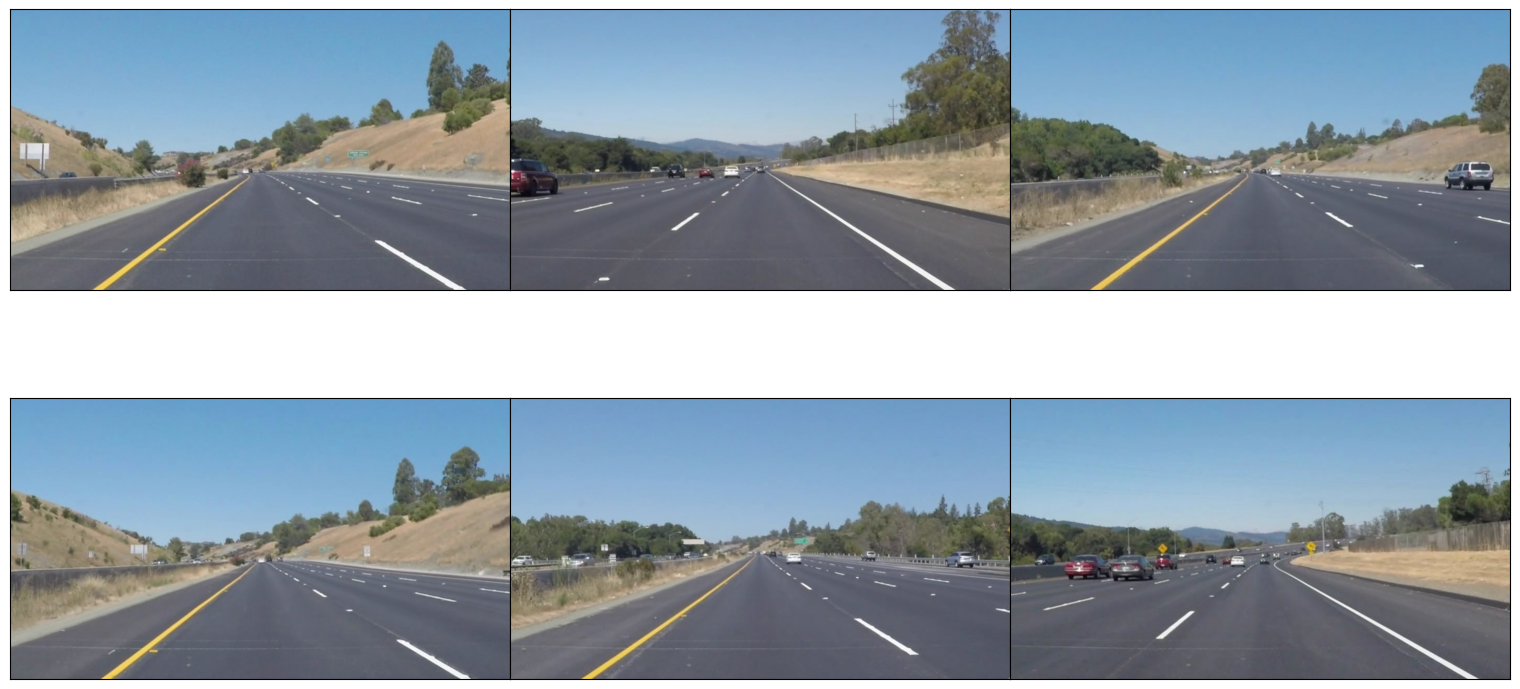

In [3]:
def showImages(images, columnCount = 3):

    rowCount = (len(images)+1)//columnCount
    plt.figure(figsize=(15, 9))
    for x, image in enumerate(images):
        plt.subplot(rowCount, columnCount, x+1)
        plt.imshow(image)            
        plt.yticks([])
        plt.xticks([])
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()


imagePathList = [imagesFolder + x for x in os.listdir(imagesFolder) if x.endswith(".jpg")]
print(imagePathList)

imageList = list(map(plt.imread, imagePathList))
showImages(imageList)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
def setConfig(width, height):
    global imgWidth
    global imgHeight
    global vertices  
    global leftLinesColl
    global rightLinesColl
    
    leftLinesColl = clx.deque(maxlen=50)
    rightLinesColl = clx.deque(maxlen=50)
    topLeft     = [width*topLeftCol, height*topLeftRow]
    topRight    = [width*topRightCol, height*topRightRow] 
    bottomLeft  = [width*bottomLeftCol, height*bottomLeftRow]
    bottomRight = [width*bottomRightCol, height*bottomRightRow]
    vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    imgWidth = width
    imgHeight = height

def hlsScale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def grayScale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, lowThreshold, highThreshold):
    return cv2.Canny(img, lowThreshold, highThreshold)

def gaussianBlur(img, kernelSize):
    return cv2.GaussianBlur(img, (kernelSize, kernelSize), 0)

def regionOfInterest(img, vertices):
    mask = np.zeros_like(img)

    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(img, mask)

def processWhiteYellow(img):
    #convert to HLS
    hlsImg = hlsScale(img)
    #masks
    whiteMaskRange = cv2.inRange(hlsImg, whiteColorLowerMask, whiteColorUpperMask)
    yellowMaskRange = cv2.inRange(hlsImg, yellowColorLowerMask, yellowColorUpperMask)
    
    #merge masks
    mergedMask = cv2.bitwise_or(whiteMaskRange, yellowMaskRange)
    
    return cv2.bitwise_and(img, img, mask = mergedMask)

def drawLines(img, lines, thickness, color=[255, 0, 0]):
    lineImage = np.zeros_like(img)
    
    for line in lines:
        if line is not None:
            cv2.line(lineImage, *line, color, thickness)

    return weightedImg(img, lineImage, 1, .95, .0)

def houghLines(img, _rho, _theta, _threshold = 20, _minLineLen = 20, _maxLineGap = 300):
    return cv2.HoughLinesP(image = img, rho= _rho, theta= _theta, threshold= _threshold, minLineLength= _minLineLen, maxLineGap = _maxLineGap)


def weightedImg(orgImg, newImg, alpha=1, beta=.95, lmb=.0):
    return cv2.addWeighted(orgImg, alpha, newImg, beta, lmb)

def avgSlopeRatio(lines):
    
    leftLines    = [] # (slope, intercept)
    leftWeights  = [] # (length,)
    rightLines   = [] # (slope, intercept)
    rightWeights = [] # (length,)
    for line in lines:
        if line is not None:
            for x1, y1, x2, y2 in line:
                if x2==x1:
                    continue # Is a vertical line ? yes -> ignore
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                length = np.sqrt((y2-y1)**2+(x2-x1)**2)
                if slope < 0: # y is reversed in image
                    leftLines.append((slope, intercept))
                    leftWeights.append((length))
                else:
                    rightLines.append((slope, intercept))
                    rightWeights.append((length))
    
    # add more weight to longer lines    
    leftLane  = np.dot(leftWeights,  leftLines) /np.sum(leftWeights)  if len(leftWeights) >0 else None
    rightLane = np.dot(rightWeights, rightLines)/np.sum(rightWeights) if len(rightWeights)>0 else None
    
    return leftLane, rightLane # (slope, intercept), (slope, intercept)

def findLinePoints(y1, y2, line):
    if line is None:
        return None
    
    ratio, intersect = line
    x1 = int((y1 - intersect) / ratio)
    x2 = int((y2 - intersect) / ratio)
    
    return ((x1, int(y1)), (x2, int(y2)))

def laneLines(lines):
    leftLane, rightLane = avgSlopeRatio(lines)
    y1 = imgHeight
    y2 = y1 * topRightRow # config param
    
    leftLine = findLinePoints(y1, y2, leftLane)
    rightLine = findLinePoints(y1, y2, rightLane)
        
    return leftLine, rightLine

def averageLine(line, lines):
    if line is not None:
        lines.append(line)

    if len(lines)>0:
        line = np.mean(lines, axis=0, dtype=np.int32)
        # convert to tuples
        line = tuple(map(tuple, line))
    return line

def processImage(img):
    whiteYellowImg = processWhiteYellow(img)

    grayImg = grayScale(whiteYellowImg)

    blurImg = gaussianBlur(grayImg, kernelSize)
    
    #https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    #https://stackoverflow.com/questions/21324950/how-can-i-select-the-best-set-of-parameters-in-the-canny-edge-detection-algorith

    highThresh, threshImg = cv2.threshold(blurImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5 * highThresh

    edges = canny(blurImg, lowThresh, highThresh)
    
    #edges = canny(blurImg, lowThreshold, highThreshold)

    regions = regionOfInterest(edges, vertices)
    lines = houghLines(regions, rho, theta, threshold, minLineLen, maxLineGap)

    leftLine, rightLine = laneLines(lines)
    
    leftLine = averageLine(leftLine, leftLinesColl)
    rightLine = averageLine(rightLine, rightLinesColl)
    
    return drawLines(img, (leftLine, rightLine), thickness)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

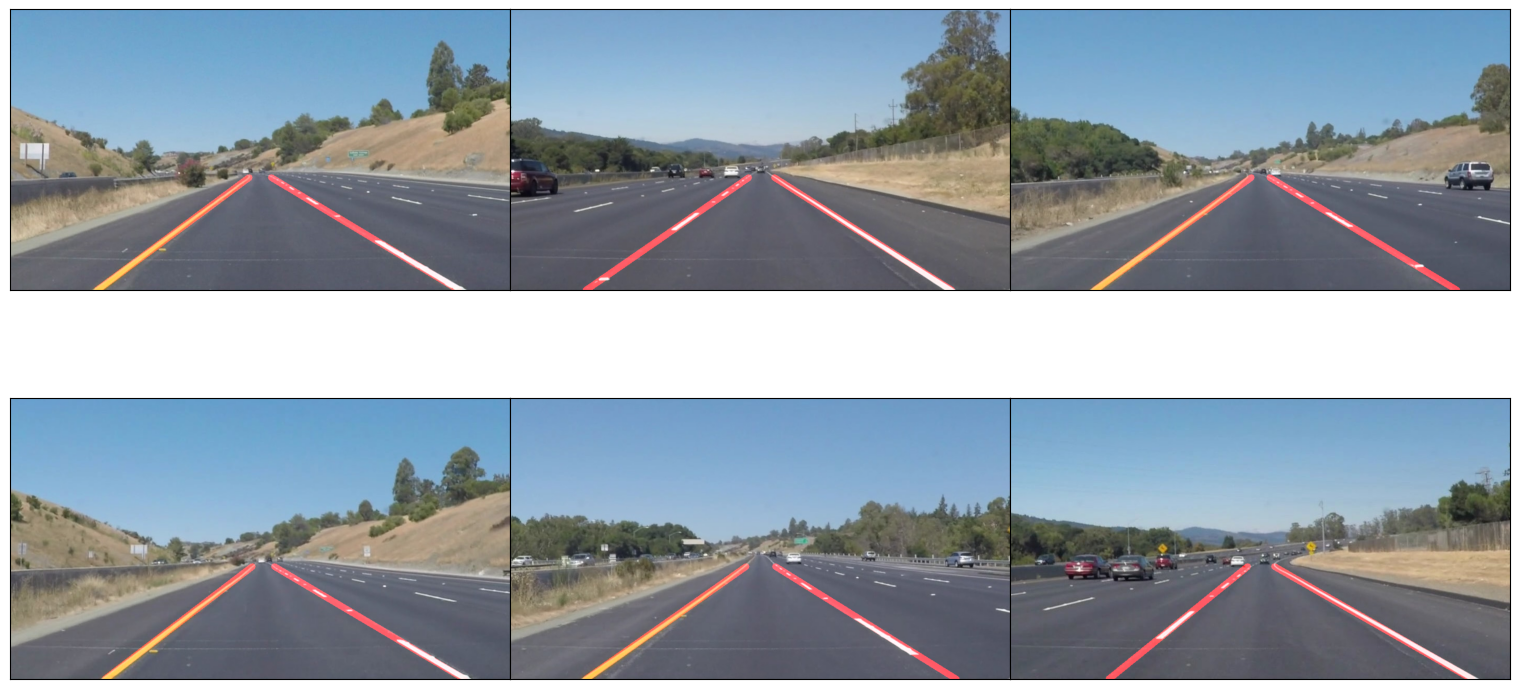

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#test 
processImageList = []
for x, image in enumerate(imageList):
    setConfig(image.shape[1], image.shape[0])
    img = processImage(image)
    cv2.imwrite(imagePathList[x].replace(imagesFolder, imagesOutputFolder), cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    processImageList.append(img)
    
showImages(processImageList)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
def processVideo(videoFileName, audioEncode = False):
    
    tempVideo = videosFolder + videoFileName
    tempVideoOutput = videosOutputFolder + videoFileName
    video = VideoFileClip(tempVideo)#.subclip(10,50)
    
    setConfig(video.w, video.h)
    
    # Fixed for MoviePy 2.x - use image_transform instead of fl_image
    output = video.image_transform(processImage) #NOTE: this function expects color images!!
    
    %time output.write_videofile(tempVideoOutput, audio = audioEncode)
    
    return tempVideoOutput

Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
whiteOutput = processVideo(solidWhiteRight)

HTML("""<video width="960" height="540" controls>  <source src="{0}"></video>""".format(whiteOutput))

MoviePy - Building video test_videos/output/solidWhiteRight.mp4.
MoviePy - Writing video test_videos/output/solidWhiteRight.mp4



MoviePy - Done !
MoviePy - video ready test_videos/output/solidWhiteRight.mp4
CPU times: user 4.5 s, sys: 3.93 s, total: 8.44 s
Wall time: 1.58 s


## Improve the drawLines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellowOutput = processVideo(solidYellowLeft)

HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(yellowOutput))

MoviePy - Building video test_videos/output/solidYellowLeft.mp4.
MoviePy - Writing video test_videos/output/solidYellowLeft.mp4



MoviePy - Done !
MoviePy - video ready test_videos/output/solidYellowLeft.mp4
CPU times: user 13.9 s, sys: 12.7 s, total: 26.6 s
Wall time: 4.74 s


## Optional Challenge

In [9]:
# optinal challenge start here
challengeOutput = processVideo(challengeVideo)

HTML("""<video width="960" height="540" controls>  <source src="{0}"></video>""".format(challengeOutput))

MoviePy - Building video test_videos/output/challenge.mp4.
MoviePy - Writing video test_videos/output/challenge.mp4



MoviePy - Done !
MoviePy - video ready test_videos/output/challenge.mp4
CPU times: user 8.59 s, sys: 6.39 s, total: 15 s
Wall time: 3.31 s
